***Библиотеки***

In [1]:
pip install dask[dataframe]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from lightgbm import LGBMClassifier
import pickle

In [3]:
# Установка пути к данным
data_folder = "./"

# Загрузка данных
users_df = pd.read_csv(data_folder + "users_df.csv")
items_df = pd.read_csv(data_folder + "items_df.csv")
train_data = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])
test_data = pd.read_csv(data_folder + "test_data.csv")
test_data = test_data.groupby("user_id").agg({"movie_id": list}).reset_index()

print("Users data:")
print(users_df.head())
print(users_df.info())

print("\nItems data:")
print(items_df.head())
print(items_df.info())

print("\nTrain data:")
print(train_data.head())
print(train_data.info())

print("\nTest data:")
print(test_data.head())
print(test_data.info())

<ipython-input-3-53f4ac1d17b6>:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])


Users data:
   user_id age_category  income      sex  kids_flg        education
0    10250        35-44     NaN      NaN       0.0           Высшее
1     2062        18-24     NaN  Женский       0.0          Среднее
2    12980        35-44     NaN  Женский       1.0  Неполное высшее
3    30646        35-44  низкий      NaN       1.0           Высшее
4    43069        25-34     NaN  Женский       NaN           Высшее
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207377 entries, 0 to 207376
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       207377 non-null  int64  
 1   age_category  180418 non-null  object 
 2   income        136235 non-null  object 
 3   sex           132623 non-null  object 
 4   kids_flg      186639 non-null  float64
 5   education     176270 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ MB
None

Items data:
   id                                 

***Визуализация_(EDA)***

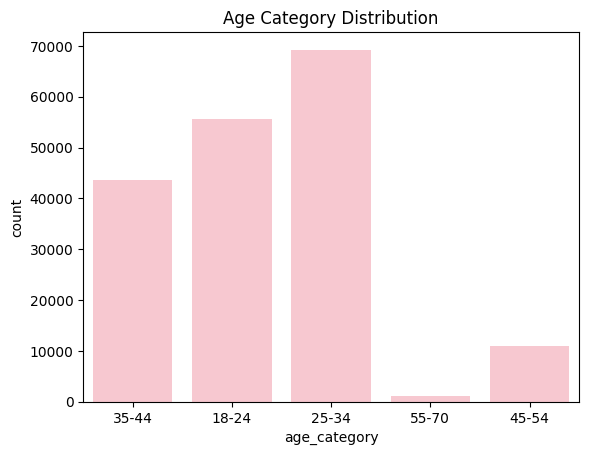

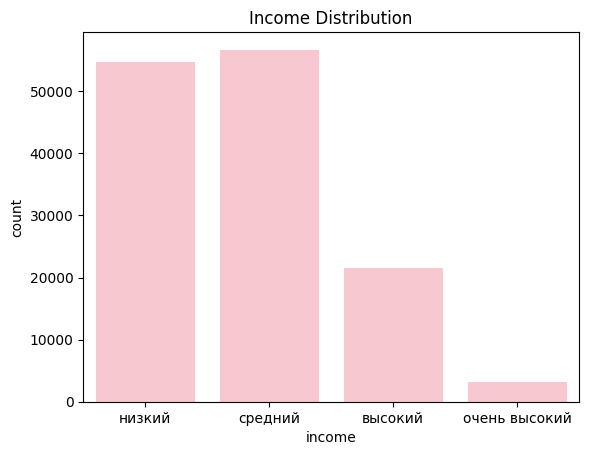

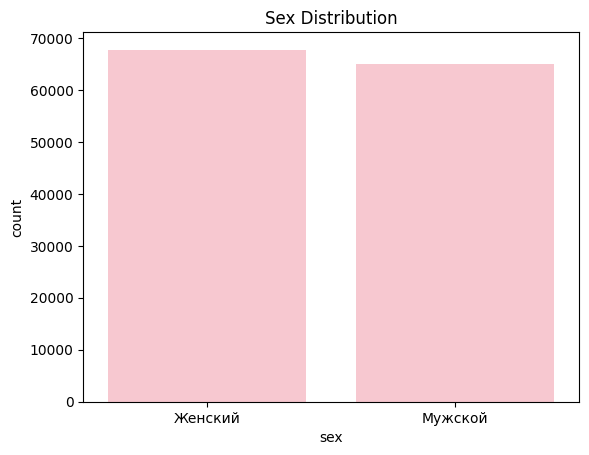

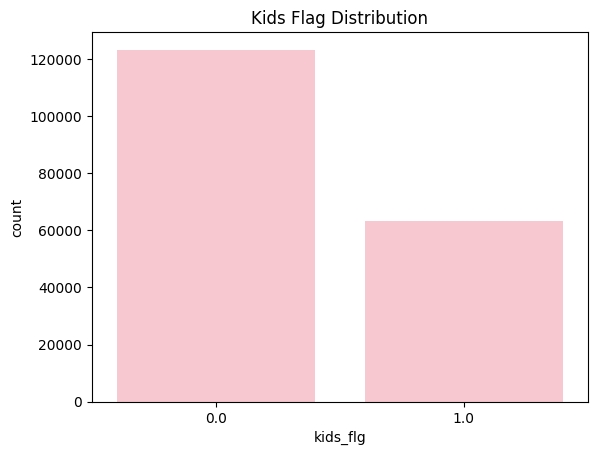

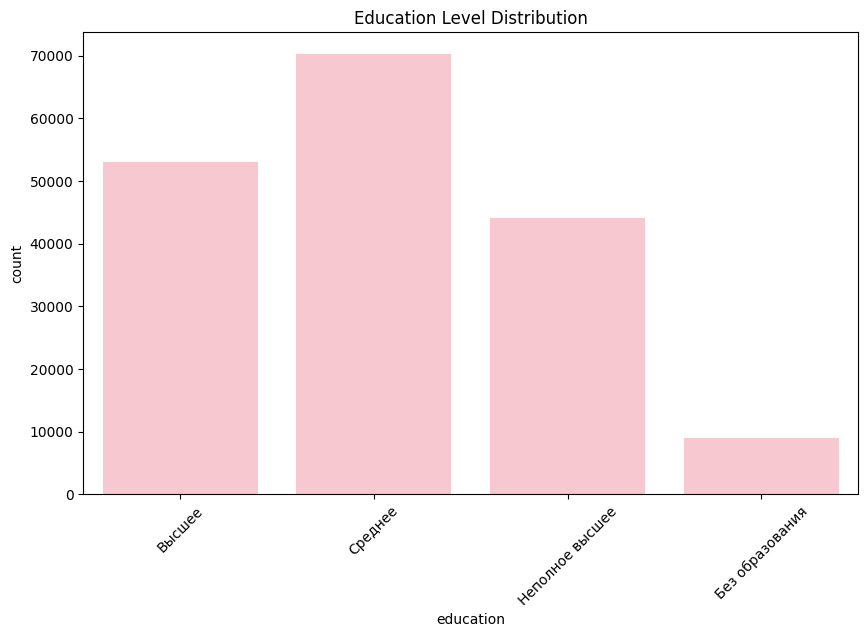

In [4]:
# Распределение возрастных категорий
sns.countplot(data=users_df, x='age_category', color = 'pink')
plt.title('Age Category Distribution')
plt.show()

# Распределение доходов
sns.countplot(data=users_df, x='income', color = 'pink')
plt.title('Income Distribution')
plt.show()

# Распределение по полу
sns.countplot(data=users_df, x='sex', color = 'pink')
plt.title('Sex Distribution')
plt.show()

# Наличие детей
sns.countplot(data=users_df, x='kids_flg', color = 'pink')
plt.title('Kids Flag Distribution')
plt.show()

# Уровень образования
plt.figure(figsize=(10, 6))
sns.countplot(data=users_df, x='education', color='pink')
plt.title('Education Level Distribution')
plt.xticks(rotation=45)
plt.show()


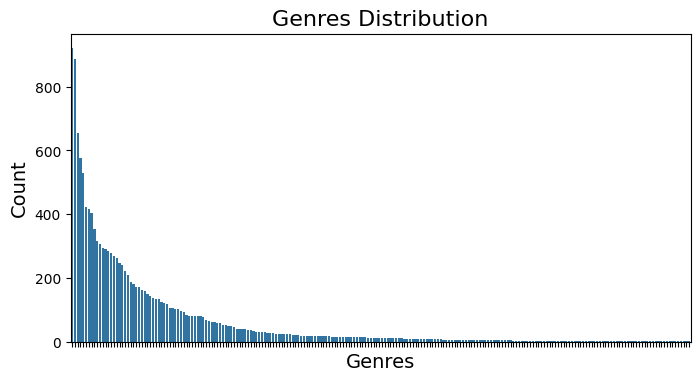

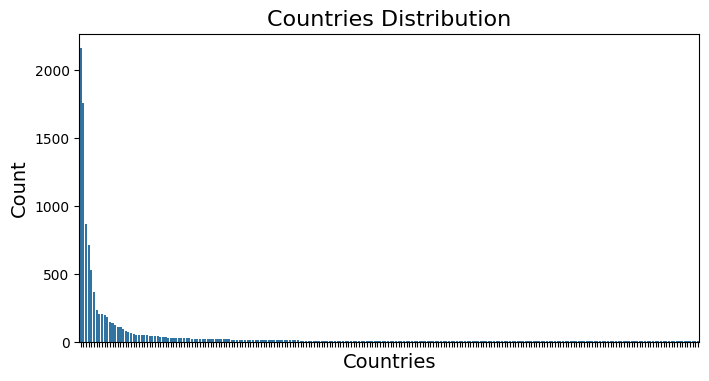

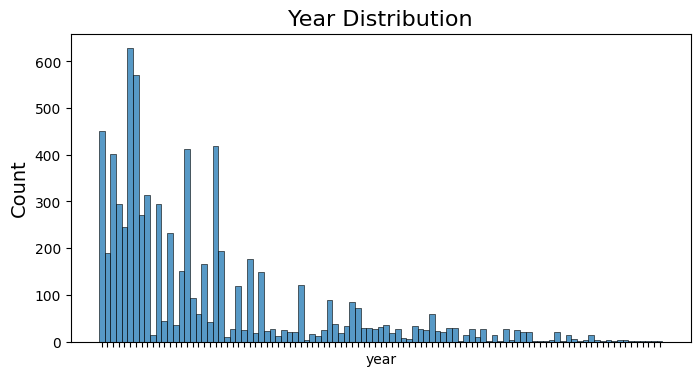

In [5]:
# Анализ жанров
genres = items_df['genres'].str.get_dummies(sep=',')
genres_sum = genres.sum().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=genres_sum.index, y=genres_sum.values)
plt.title('Genres Distribution', fontsize=16)
plt.xticks(fontsize=12, visible=False)
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Анализ стран
countries = items_df['countries'].str.get_dummies(sep=',')
countries_sum = countries.sum().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=countries_sum.index, y=countries_sum.values)
plt.title('Countries Distribution', fontsize=16)
plt.xlabel('Countries', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90, fontsize=12, visible=False)
plt.show()

# Год выхода фильмов
plt.figure(figsize=(8, 4))
sns.histplot(items_df['year'], bins=30)
plt.title('Year Distribution', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, visible=False)
plt.show()


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Замена пропущенных значений на пустые строки
items_df['title'].fillna('', inplace=True)
items_df['description'].fillna('', inplace=True)
items_df['keywords'].fillna('', inplace=True)

# Объединение текстовых данных
items_df['text_data'] = items_df['title'] + ' ' + items_df['description'] + ' ' + items_df['keywords']

# Векторизация текстовых данных с использованием TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
tfidf_matrix = tfidf.fit_transform(items_df['text_data'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)


TF-IDF matrix shape: (7427, 10000)


In [7]:
# Кодирование категориальных признаков в users_df
label_encoders = {}
for column in ['age_category', 'income', 'education']:
    le = LabelEncoder()
    users_df[column] = le.fit_transform(users_df[column])
    label_encoders[column] = le

print(users_df.head())


   user_id  age_category  income      sex  kids_flg  education
0    10250             2       4      NaN       0.0          1
1     2062             0       4  Женский       0.0          3
2    12980             2       4  Женский       1.0          2
3    30646             2       1      NaN       1.0          1
4    43069             1       4  Женский       NaN          1


***фича(продолжение анализа)***

In [8]:
# Количество жанров
items_df['num_genres'] = items_df['genres'].apply(lambda x: len(x.split(',')))

# Количество стран
items_df['num_countries'] = items_df['countries'].apply(lambda x: len(x.split(',')))

print(items_df[['num_genres', 'num_countries']].head())


   num_genres  num_countries
0           1              1
1           3              1
2           2              2
3           4              3
4           2              3


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from lightgbm import LGBMClassifier
import pickle
from scipy.sparse import csr_matrix
data_folder = "./"

# Загрузка данных
users_df = pd.read_csv(data_folder + "users_df.csv")
items_df = pd.read_csv(data_folder + "items_df.csv")
train_data = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])
test_data = pd.read_csv(data_folder + "test_data.csv")
test_data = test_data.groupby("user_id").agg({"movie_id": list}).reset_index()

<ipython-input-9-526c934e0c66>:18: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])


In [10]:
# Проверка и преобразование столбца 'is_train'
print("\nChecking 'is_train' column values:")
print(train_data['is_train'].unique())

# Преобразование столбца 'is_train' в булевый тип, если необходимо
if train_data['is_train'].dtype != 'bool':
    train_data['is_train'] = train_data['is_train'].astype(bool)

# Фильтрация данных для создания матрицы взаимодействий
train_data_filtered = train_data[train_data['is_train'] == True]

# Создание матрицы взаимодействий
interaction_matrix = train_data_filtered.pivot_table(index='user_id', columns='movie_id', values='duration', fill_value=0)
print("Interaction matrix shape:", interaction_matrix.shape)

# Преобразование DataFrame в разреженную матрицу формата CSR
interaction_matrix_csr = csr_matrix(interaction_matrix.values)


Checking 'is_train' column values:
[True nan]
Interaction matrix shape: (122072, 5073)


***Обучение модели: демонстрация подхода***

In [11]:
!pip install implicit
from implicit.als import AlternatingLeastSquares

In [12]:
# Обучение модели ALS
model_als = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=20)
model_als.fit(interaction_matrix_csr.T)

# Пример рекомендации с использованием ALS
user_id = test_data['user_id'].iloc[0]
user_interactions = interaction_matrix.loc[user_id].values.reshape(1, -1)
recommended_items_als = model_als.recommend(user_id, csr_matrix(user_interactions), N=10)
print("Recommended items for user with ALS:", recommended_items_als)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.014952659606933594 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

Recommended items for user with ALS: (array([   473,   5412,  37328,  31193,   7889,  55094, 114788,   1182,
        69639,   1664], dtype=int32), array([1.0327806 , 1.0069901 , 0.99494445, 0.97853607, 0.97546947,
       0.9726123 , 0.9633089 , 0.9597597 , 0.91279227, 0.8835203 ],
      dtype=float32))


In [13]:
# Обучение модели LightGBM
X_train = train_data.drop(columns=['duration', 'datetime', 'is_train'])  # Удаляем столбцы 'datetime' и 'is_train'
y_train = train_data['duration'] > 0  # Бинарная метка

# Убедимся, что X_test имеет такие же столбцы, как и X_train
X_test = test_data.drop(columns=['movie_id'])  # Удаляем столбец 'movie_id', так как он не используется в обучении
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)  # Присваиваем те же столбцы, что и в X_train

model_lgb = LGBMClassifier()
model_lgb.fit(X_train, y_train)

# Пример предсказания с использованием LightGBM
predictions = model_lgb.predict(X_test)
print("Predictions with LightGBM:", predictions)

[LightGBM] [Info] Number of positive: 674671, number of negative: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 674672, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.999999 -> initscore=13.421980
[LightGBM] [Info] Start training from score 13.421980
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

***Оценка моделей***

In [14]:
# Проверка наличия user_id в interaction_matrix
if user_id not in interaction_matrix.index:
    raise ValueError(f"User ID {user_id} not found in interaction_matrix")

# Пример рекомендации с использованием ALS
user_interactions = interaction_matrix_csr[interaction_matrix.index.get_loc(user_id)].toarray().reshape(1, -1)
recommended_items_als = model_als.recommend(user_id, csr_matrix(user_interactions), N=10)
recommended_items_als_ids = [item[0] for item in recommended_items_als]
print("Recommended items for user with ALS:", recommended_items_als_ids)

Recommended items for user with ALS: [473, 1.0327806]


In [15]:
# Метрики Precision@k и Recall@k

def precision_at_k(recommended_items, relevant_items, k):
    recommended_items_at_k = recommended_items[:k]
    return len(set(recommended_items_at_k) & set(relevant_items)) / k

def recall_at_k(recommended_items, relevant_items, k):
    recommended_items_at_k = recommended_items[:k]
    return len(set(recommended_items_at_k) & set(relevant_items)) / len(relevant_items)

# Пример оценки для моделей
relevant_items = train_data[train_data['user_id'] == user_id]['movie_id'].tolist()

# Оценка ALS
print("Precision@5 for ALS:", precision_at_k(recommended_items_als_ids, relevant_items, 5))
print("Recall@5 for ALS:", recall_at_k(recommended_items_als_ids, relevant_items, 5))

Precision@5 for ALS: 0.0
Recall@5 for ALS: 0.0


In [16]:
# Пример анализа рекомендаций
def analyze_recommendations(recommended_items):
    genres = items_df[items_df['id'].isin(recommended_items)]['genres']
    genres_count = genres.str.get_dummies(sep=',').sum().sort_values(ascending=False)
    return genres_count

recommended_items_als = [item[0] for item in recommended_items_als]
print("Genres distribution for ALS recommendations:")
print(analyze_recommendations(recommended_items_als))


Genres distribution for ALS recommendations:
 326]    1
[303     1
dtype: int64


***EDA полученных рекомендаций***

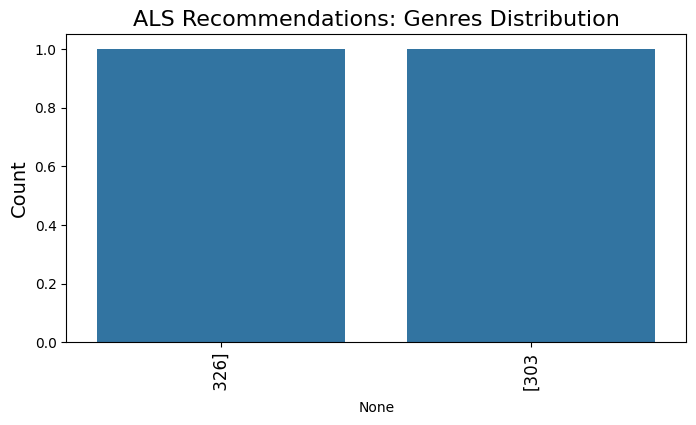

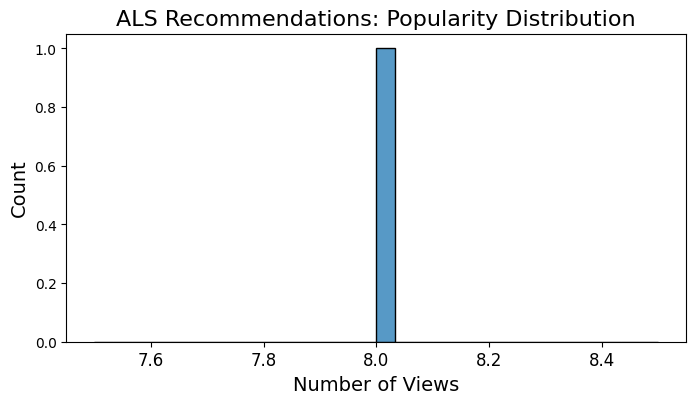

ALS Recommendations: Number of Unique Items: 2


In [17]:
def analyze_recommendations(recommended_items, model_name):
    # Анализ жанров
    genres = items_df[items_df['id'].isin(recommended_items)]['genres']
    genres_count = genres.str.get_dummies(sep=',').sum().sort_values(ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=genres_count.index, y=genres_count.values)
    plt.title(f'{model_name} Recommendations: Genres Distribution', fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=90, fontsize=12)
    plt.show()

    # Анализ популярности
    popularity = train_data[train_data['movie_id'].isin(recommended_items)]['movie_id'].value_counts()

    plt.figure(figsize=(8, 4))
    sns.histplot(popularity, bins=30)
    plt.title(f'{model_name} Recommendations: Popularity Distribution', fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('Number of Views', fontsize=14)
    plt.xticks(fontsize=12)
    plt.show()

    # Количество уникальных фильмов
    unique_items = len(recommended_items)
    print(f'{model_name} Recommendations: Number of Unique Items:', unique_items)

# Анализ рекомендаций ALS
analyze_recommendations(recommended_items_als_ids, 'ALS')


***Сохраним модель***

In [18]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(model_als, f)
